# Подбор гиперпараметров модели и кросс-валидация

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [3]:
wine = load_wine()

In [39]:
# Разделение выборки на обучающую и тестовую
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, random_state=1)

In [40]:
# В моделях k-ближайших соседей большое значение k 
# ведёт к большому смещению и низкой дисперсии (недообучению)
# 20 ближайших соседей
cl1_1 = KNeighborsClassifier(n_neighbors=10)
cl1_1.fit(wine_X_train, wine_y_train)
target1_0 = cl1_1.predict(wine_X_train)
target1_1 = cl1_1.predict(wine_X_test)
accuracy_score(wine_y_train, target1_0), accuracy_score(wine_y_test, target1_1)

(0.7580645161290323, 0.6666666666666666)

In [41]:
def accuracy_score_for_classes(
    y_true: np.ndarray,
    y_pred: np.ndarray) -> {int:float}:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [42]:
print_accuracy_score_for_classes(wine_y_test, target1_1)

Метка 	 Accuracy
0 	 0.782608695652174
1 	 0.6842105263157895
2 	 0.4166666666666667


# Матрица ошибок

In [43]:
# Пример для небинарной классификации
cm = confusion_matrix(wine_y_test, target1_1, labels=[0, 1, 2])

In [44]:
cm

array([[18,  0,  5],
       [ 1, 13,  5],
       [ 0,  7,  5]], dtype=int64)

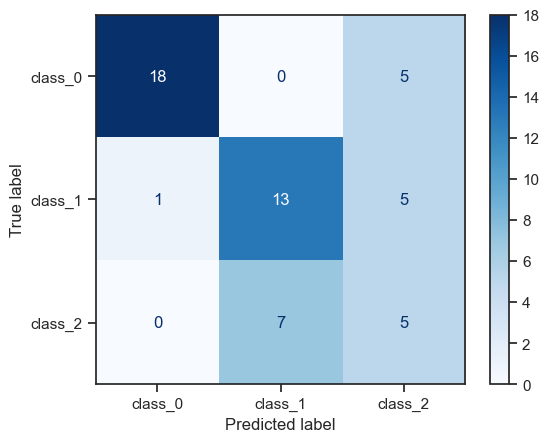

In [45]:
ConfusionMatrixDisplay(cm, display_labels=wine.target_names).plot(cmap="Blues")

In [46]:
precision_score(wine_y_test, target1_1, average='micro')

0.6666666666666666

In [47]:
precision_score(wine_y_test, target1_1, average='macro')

0.6435672514619882

In [48]:
precision_score(wine_y_test, target1_1, average='weighted')

0.7062865497076023

# ROC кривые

In [49]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [50]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [51]:
bin_cl1_1 = KNeighborsClassifier(n_neighbors=10)
bin_wine_y_train = convert_target_to_binary(wine_y_train, 0)
bin_wine_y_test = convert_target_to_binary(wine_y_test, 0)
bin_cl1_1.fit(wine_X_train, bin_wine_y_train)
bin_cl1_1.predict(wine_X_test)

bin_target1_1 = convert_target_to_binary(target1_1, 2)

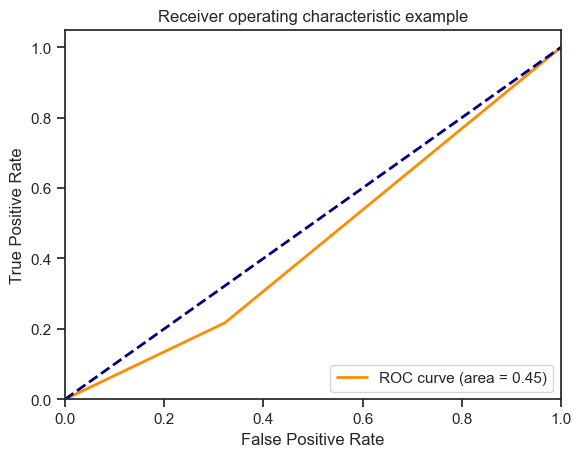

In [52]:
draw_roc_curve(bin_wine_y_test, bin_target1_1, pos_label=1, average='micro')

# GridSearch

In [53]:
n_range = np.array(range(5,40,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35])}]

In [54]:
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(wine_X_train, wine_y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35])}],
             scoring='accuracy')

In [55]:
clf_gs.best_score_, clf_gs.best_params_

(0.7340000000000001, {'n_neighbors': 20})

# Randomized Search

In [56]:
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_rs.fit(wine_X_train, wine_y_train)

C:\Users\prite\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35])}],
                   scoring='accuracy')

In [57]:
clf_rs.best_score_, clf_rs.best_params_

(0.7340000000000001, {'n_neighbors': 20})

# Кросс валидация

## KFold

In [58]:
kf = KFold(n_splits=3)
scores = cross_val_score(clf_rs.best_estimator_, 
                         wine.data, wine.target, cv=kf)

In [59]:
# Значение метрики accuracy для 3 фолдов
scores

array([0.01666667, 0.        , 0.18644068])

## Shuffle split

In [60]:
# Эквивалент KFold(n_splits=n)
kf_sp = ShuffleSplit(n_splits=5, test_size=0.25)

In [61]:
scores_sp = cross_val_score(clf_rs.best_estimator_, 
                         wine.data, wine.target, cv=kf)

In [62]:
scores_sp

array([0.01666667, 0.        , 0.18644068])

# Метрики оптимальной модели

In [63]:
print_accuracy_score_for_classes(wine_y_test, target1_1)

Метка 	 Accuracy
0 	 0.782608695652174
1 	 0.6842105263157895
2 	 0.4166666666666667


In [64]:
target2 = clf_rs.predict(wine_X_test)

In [65]:
cm = confusion_matrix(wine_y_test, target2, labels=[0, 1, 2])

In [66]:
cm

array([[19,  0,  4],
       [ 1, 15,  3],
       [ 0,  6,  6]], dtype=int64)

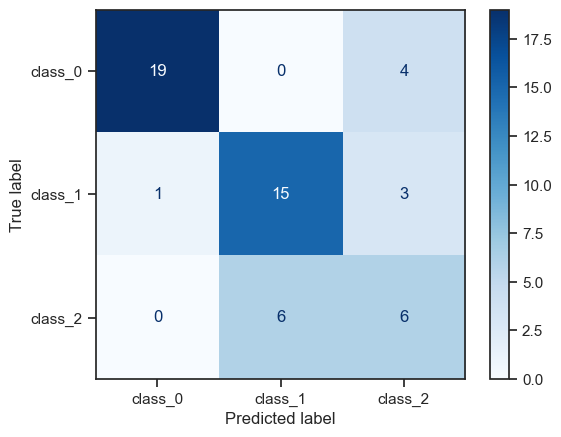

In [67]:
ConfusionMatrixDisplay(cm, display_labels=wine.target_names).plot(cmap="Blues")

In [68]:
precision_score(wine_y_test, target2, average='micro')

0.7407407407407407

In [69]:
precision_score(wine_y_test, target2, average='macro')

0.7086080586080586

In [70]:
precision_score(wine_y_test, target1_1, average='weighted')

0.7062865497076023

In [71]:
bin_clf_rs = KNeighborsClassifier(n_neighbors=20)
bin_wine_y_train = convert_target_to_binary(wine_y_train, 0)
bin_wine_y_test = convert_target_to_binary(wine_y_test, 0)
bin_clf_rs.fit(wine_X_train, bin_wine_y_train)
bin_clf_rs.predict(wine_X_test)

bin_target2 = convert_target_to_binary(target2, 2)

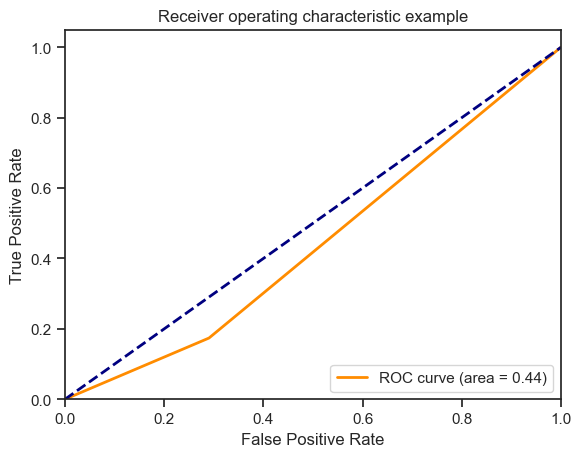

In [72]:
draw_roc_curve(bin_wine_y_test, bin_target2, pos_label=1, average='micro')

# Вывод

Отличия оптимальной модели от исходной: 
- имеет accuracy по каждому классу выше исходной
- совершает меньше ошибок (видно на матрице ошибок)
- имеет ROC - кривую ниже, что говорит о больших ошибках первого рода